# Augmentation and Transfer Learning

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import *

## Augmentation

Augmentation wird im Training des Netzes genutzt, um Overfitting zu vermeiden und das Modell stabiler gegenüber leichten Änderungen in den Inputs zu machen. Die Bilder werden dafür bei jeder Epoche etwas verändert.

### Ein paar Möglichkeiten

Wir werden jetzt verschiedenen Funktionen, die für Augmentation benutzt werden können, ansehen. Es ist nur eine kleine Auswahl dessen was möglich ist. Weitere Möglichkeiten hier: https://docs.fast.ai/vision.transform.html

Lade Dein Lieblings-Bild hoch. Wir werden mit dem Bild verschiedene Augmentation-Möglichkeiten ausprobieren. Die `plot_f` Funktion zeigt 8 Bilder, die mit den gewählten Transformation ver grössert war.

*Bermerkung*: am besten keine symmetrische Musterbild hochladen, um die Effekten von Augmentation Rate besser zu sehen.

In [3]:
def get_ex(): return open_image('datasets/tableware/mug/mug_6.jpg')

tfms = get_transforms()
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

#### Using get_transforms()

Die `get_transforms()` Funktion stellt mehrere Transformation bereit, dass man auch kombinieren kann. Ersmal schauen wir und eine reguläre "Flip" Transformation.

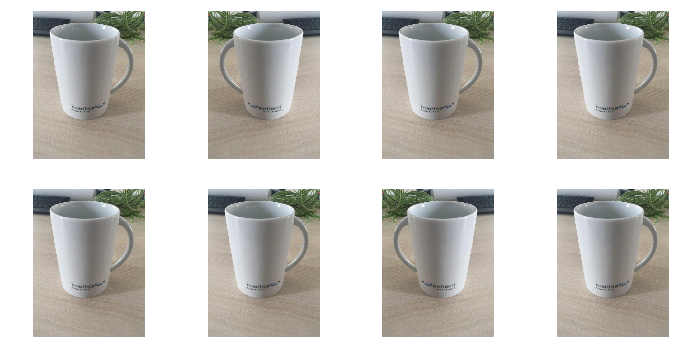

In [11]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_zoom=0, max_lighting=0, max_warp=0)
plots_f(2, 4, 12, 6, size=None)

Dann können wir auch die anderen Parametern ändern, um das Bild mit anderen Transformationen zu bearbeiten: Rotation, Zoom, Beleuchtung und Verformung

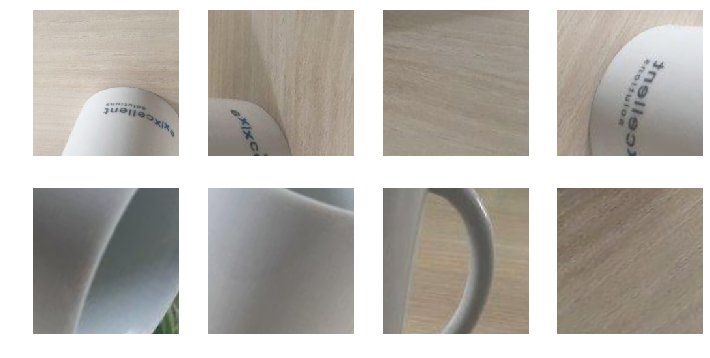

In [15]:
tfms = get_transforms(do_flip=True, max_rotate=180, max_zoom=5, max_lighting=0.2, max_warp=0, p_lighting=1)
plots_f(2, 4, 12, 6, size=224)

Es muss immer beachtet werden, welche Transformationen für das Bildmaterial sinnvoll sind. Abhängig von den Parametern können Bilder entstehen, die nicht mehr viel mit dem ursprünglichen Bild zu tun haben. In dem Bild unten (mit den oberen Parametern generiert) sieht man, dass das 3. Bild auf der unteren Reihe nicht sinnvoll ist: die Tasse fehlt, es ist nur noch der Tisch zu sehen... Sind die anderen Bilder für unser Training relevant und die Transformation gut gewählt?

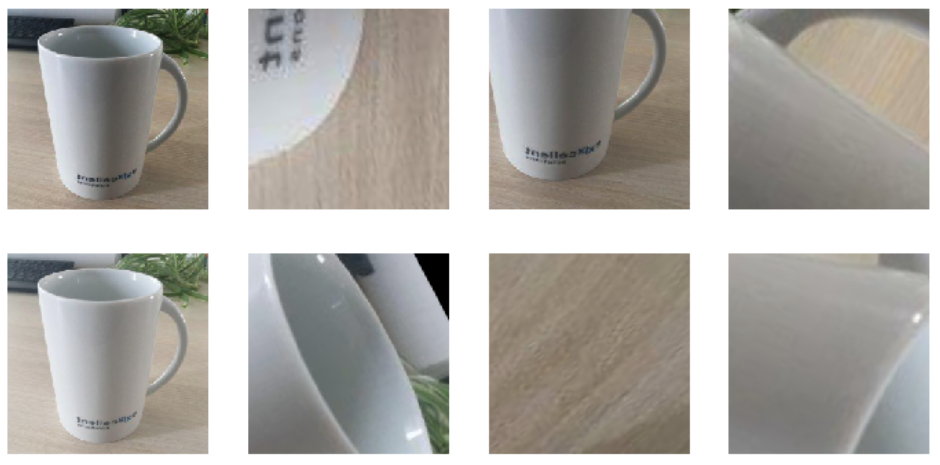

In [6]:
img_notOk = open_image('images/image_not_ok.PNG')
img_notOk

#### Using zoom_crop()

Die `zoom_crop()` Funktion kann die Bilder vergrößern und beschneiden.

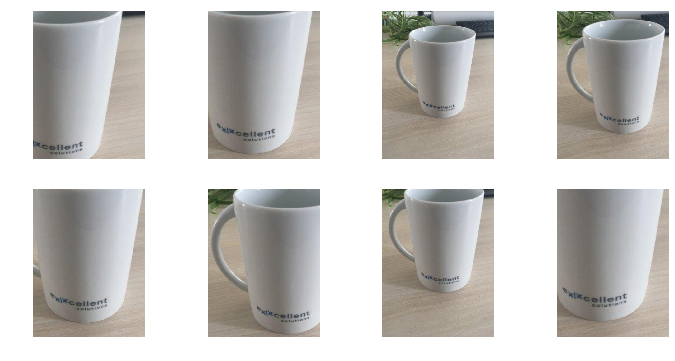

In [17]:
tfms = zoom_crop(scale=(0.75,2), do_rand=True)
plots_f(2, 4, 12, 6, size=None)

#### Using rand_resize_crop()

Die `rand_resize_crop()` Funktion kann die Bilder vergrössern und beschneiden.

Diese Transformation ist eine Implementierung des Hauptansatzes, der für fast alle erfolgreichen `ImageNet` Anwendungen seit 2013 verwendet wird. Es basiert auf dem Artikel von Andrew Howard: Some Improvements on Deep Convolutional Neural Network Based Image Classification.

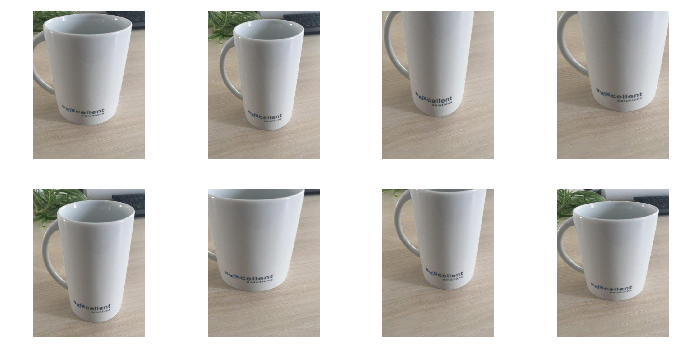

In [18]:
tfms = rand_resize_crop(224)
plots_f(2, 4, 12, 6, size=None)

### Ergebnisse mit und ohne Augmentation Rate

Wir werden hier mit den Blättern weiter machen.

In [78]:
path = Path('datasets/leaves')

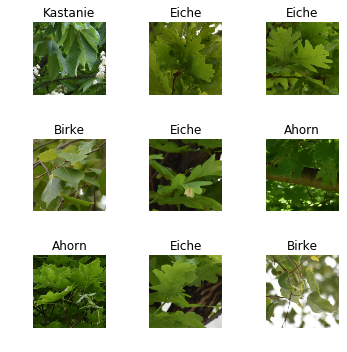

In [148]:
np.random.seed(1337)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, bs=10,
                                  size=224).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(5,5))

In [154]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.852863,1.513363,0.768508,00:03
1,1.794809,1.360190,0.626322,00:03
2,1.540718,1.151674,0.492362,00:03
3,1.249978,0.977667,0.366627,00:03
4,1.019022,0.849727,0.317274,00:03
5,0.850879,0.750908,0.274971,00:03
6,0.719284,0.696063,0.244418,00:03
7,0.622062,0.650040,0.233843,00:03
8,0.546360,0.629170,0.220917,00:03
9,0.484186,0.604839,0.211516,00:03


Mit Augmentation: wir benutzen den Parameter `ds_tfms`

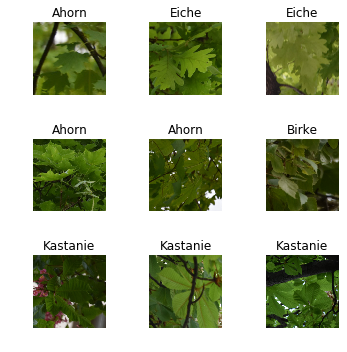

In [150]:
np.random.seed(1337)
data_augmented = ImageDataBunch.from_folder(path, valid_pct=0.2, bs=10,
                                         ds_tfms=get_transforms(do_flip=True, max_rotate=10, max_zoom=0.1, max_warp=0.1, max_lighting=0.2),
                                         size=224).normalize(imagenet_stats)
data_augmented.show_batch(rows=3, figsize=(5,5))

In [156]:
learn_augmented = cnn_learner(data_augmented, models.resnet34, metrics=error_rate)
learn_augmented.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.150929,1.467158,0.747356,00:03
1,1.774688,1.140012,0.485311,00:03
2,1.448255,0.953444,0.341951,00:03
3,1.213896,0.855888,0.307873,00:03


Probieren wir es jetzt mit die Tableware. Wie sehen die Ergebnisse aus?

*Bemerkung* : es kann sein, dass die Augmentation nicht hilft, unsere Ergebnisse besser zu machen. Zum Beispiel, wenn die Transformationen nicht gut gewählt sind oder das Modell nicht so lange trainiert wird, dass die Transformationen große Wirkung entfalten.

## Transfer Learning

Wir werden das Beispiel mit dem Geschirr benutzen. Da hatten wir gute Ergebnisse mit einem vortrainierten CNN-Modell erhalten.

Erst muss man die Daten wieder vorbereiten

In [157]:
path = Path('datasets/tableware')
np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=10,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Dann erstellen wir das vortrainierte Modell (`pretrained=True`), also mit Transfer Learning. Wenn man den Parameter nicht spezifiziert, wird automatisch Transfer Learning genutzt.

In [159]:
learn_withTL = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)
learn_withTL.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.396034,0.509646,0.133333,00:01
1,0.796785,0.168251,0.000000,00:01
2,0.531727,0.093663,0.000000,00:01
3,0.405067,0.062321,0.000000,00:01


Dann ohne Transfer Learning (`pretrained=False`)

In [160]:
learn_withoutTL = cnn_learner(data, models.resnet34, pretrained=False, metrics=error_rate)
learn_withoutTL.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.286739,1.127737,0.666667,00:01
1,1.328020,1.408831,0.800000,00:01
2,1.190617,1.143601,0.733333,00:01
3,1.173522,1.012925,0.533333,00:01


Wir merken, dass die Ergebnisse ohne Transfer Learning schlechter sind als mit. Wir können uns auch die Confusion Matrix ansehen.

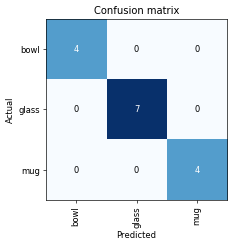

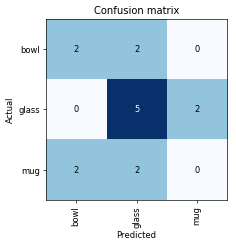

In [17]:
interp_withTL = ClassificationInterpretation.from_learner(learn_withTL)
interp_withTL.plot_confusion_matrix(figsize=(4,4), dpi=60)

interp_withoutTL = ClassificationInterpretation.from_learner(learn_withoutTL)
interp_withoutTL.plot_confusion_matrix(figsize=(4,4), dpi=60)

Mit dem gleichen Datensatz sind die Ergebnisse viel zuverlässiger, wenn das Modell vortrainiert war.

*Bemerkung : Wenn wir den gleichen Code wieder ausführen, bekommen wir nicht die gleichen Ergebnisse, da die Bildauswahl zufällig ist.*

### Unfreeze

Mit `unfreeze()` kann man statt nur die letzten Schichten auch die ersten Schichten des Modells trainieren lassen.

In [18]:
learn_unfreeze = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)
learn_unfreeze.fit_one_cycle(4)

learn_unfreeze.unfreeze()
learn_unfreeze.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.279822,0.522705,0.000000,00:01
1,0.773650,0.092222,0.000000,00:01
2,0.537387,0.068727,0.000000,00:01
3,0.389530,0.072053,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.171201,0.545102,0.200000,00:01
1,0.200397,0.257087,0.133333,00:01


*Bemerkung*: In diesem Fall sind die Ergebnise mit `unfreeze()` nicht besser geworden. Im nächsten Notebook werden wir sehen, wie man auch die ersten Schichten richtig trainiert unter Nutzung der *learning rate*.

## Hands on

1. Mit seinen eigenen Bilder probieren
    1. Welche Transformationen sind für mich interessant?
    2. Welche Werte soll ich für meine Bilder wählen? 
2. Andere Augmentation-Möglichkeiten von 'https://docs.fast.ai/vision.transform.html' probieren.
3. "Augmente" deine Bilder und probiere das Transfer Learning aus. Vergleich die Ergebnisse (ohne Augmentation, mit TL), (ohne Aug, ohne TL), (mit Aug, ohne TL), (mit Aug, mit TL)